### Acoustic fingerprinting

The solution will consists of three separate components:
1. Create fingerprints of all songs in the database: Code that creates an unique audio fingerprint of each song in the database
2. Take FFT of a short audio snippet : Code that makes Fourier transforms of a short snippet
3. Matching algorithm: Algorithm that has two functions:
<br>
    3.1. Matches the FFT of the short audio snippet to each of the fingerprints in the database
<br>
    3.2. Returns a list of songs from the database whose fingerprints are closely matching to the short audio snippet

In [2]:
import matplotlib.pyplot as plt
from scipy.fftpack import fft, dct
from scipy.io import wavfile
from scipy.signal import blackman, hanning, hamming
import numpy as np
from scipy import signal
import os

%matplotlib inline


# Location of the song
files_location = "C:/Users/bre49823/Google Drive/MusicEngine/wav/" # "/Users/valentin/Documents/MusicEngine/wav/test/"
songs_list = os.listdir(files_location)

songs_list = songs_list[0]
song_name = songs_list.split(".wav")[0]

### Read in the data and create a plot of the raw audio file
The raw data is in the time domain and using Fourier transform I'll convert it to frequency spectrum

In [3]:
# Read in the raw audio data and get the sample rate (in samples/sec)
sample_rate, soundtrack_data = wavfile.read(files_location + songs_list)
audio_data = soundtrack_data.T[0]                     # this is a two channel soundtrack, get only one of the tracks
audio_data = audio_data[0:int(2 * sample_rate)]       # keep only the first 10 seconds

time = np.arange(0, float(audio_data.shape[0]), 1) / sample_rate

### Apply pre-emphasis filter to the raw audio data
This makes the signal cleaner with less noise. It is done to balance the frequency spectrum since high frequencies have lower magnitude than lower frequncies.
<br>
The pre-emphasis filter is y(t) = x(t) - emphasis_coeff * (t - 1)
<br>
Typical values for the emphasis coefficients are 0.95 and 0.97

In [4]:
# Apply pre-emphasis filter to the raw audio data
emphasis_coeff = 0.95
emphasized_audio_data = np.append(audio_data[0], audio_data[1:] - emphasis_coeff * audio_data[:-1])

### Split the audio data into frames
When we apply Fourier transform it needs to be applied over short chunks of the raw audio data. The frequencies in the audio signal change over time, and if we do the transformation using the whole length of the song, we would lose these changes in frequencies.
<n>
The frames need to be overlapping. According to Haytham Fayek (http://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html), frame sizes for speech processing range from 20ms to 40ms with 50%(+/-10%) overlap between consecutive frames.
<n>
I'll use 25ms for the frame size and 15ms overlap. The difference between the frame length and the overlap is called a stride (i.e. stride = frame length - overlap)

In [5]:
frame_size = 0.025
frame_overlap = 0.015

audio_signal = audio_data

# Calculate the length of each frame and the step for moving forward the FFT
frame_stride = round(frame_size - frame_overlap, 3)
frame_length, frame_step = int(round(frame_size * sample_rate)), int(round(frame_stride * sample_rate))

# Calculate the total number of frames
signal_length = len(audio_signal)
number_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))

# Pad the raw signal data with zeros to make sure that all frames have equal number of samples
pad_audio_length = number_frames * frame_step + frame_length          # This number should be very close to the audio signal length. The difference is caused by the rounding in the calculation of number_frames
zeros_vector = np.zeros((pad_audio_length + signal_length))
pad_signal = np.append(audio_signal, zeros_vector)

# Validation of the data
print (frame_stride, frame_length, frame_step, signal_length, number_frames)
print (signal_length, pad_audio_length, zeros_vector.shape, pad_signal.shape)

(0.01, 1103, 441, 88200, 198)
(88200, 88421, (176621L,), (264821L,))


In [6]:
int(np.ceil(float(np.abs(signal_length - frame_length)))) / frame_step

197

In [7]:
# frames_idx[] is just an array index which is used to split the pad_signal[] array
frames_idx = np.tile(np.arange(0, frame_length), (number_frames, 1)) + np.tile(np.arange(0, number_frames * frame_step, frame_step), (frame_length, 1)).T 
signal_frames = pad_signal[frames_idx.astype(np.int32 , copy = False)]

print (signal_frames.shape, frames_idx.shape)
signal_frames[1, 100:110]
#np.savetxt("C:/Users/bre49823/Desktop/signal_frames_before_hamming.csv", signal_frames, delimiter = ",")

((198L, 1103L), (198L, 1103L))


array([ -7., -11., -15., -20., -25., -33., -40., -42., -45., -50.])

### Create a window function for the Fourier transform
_(source of pictures: http://www.opentextbooks.org.hk/ditatopic/9759)_
<p>
The windows are used for smoothing values of the raw signal in each time frame. They smooth the discontinuities at the end of the frames of the raw signal, and help with spectral leakage, performing anti alising.
<br>

There are three widely used windows in the DSP literature - Hanning, Hamming and Blackman:
###### Hamming window
$$w(n) = 0.54 - 0.46\cos\frac{2\pi n}{N - 1}, where\  0 <= n <= N - 1$$
###### Hanning window
$$w(n) = 0.5 - 0.5\cos\frac{2\pi n}{N - 1}, where\  0 <= n <= N - 1$$
###### Blackman window
$$w(n) = 0.42 - 0.5\cos\frac{2\pi n}{N} + 0.08\cos\frac{4\pi n}{N}$$

_(More can be found here https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.window.html)_


<br>
###### Rectangular window includes additional periods at the beginning and end of the time frames and causes spectral leakage
Using a rectangular window includes more time periods at the beginning and end of a window, which creates spectral leakage. Also when using a rectangular window the Fourier transform produces a noisy spectrogram. That's why we need to use on the windows discussed above - Hamming, Hanning or Blackman.
![title](files/spectrogram_hanning_vs_rectangular.png)
###### Fourier transform should be calculated using overlapping windows
The windowing functions discussed here are tapered at the ends, which modulates the amplitudes and creates sin wave type of a signal. This can be seen on the picture below. Therefore, the windows need to be overlapped.
![title](files/spectrogram_with_non_overlapping_windows.png)
###### Spectrogram with overlapping windows
To alleviate the modulated amplitude of the raw signal, frames are overlapped (typically by half a frame duration). This solution requires more Fourier transform calculations than needed by rectangular windowing, but the spectra are much better behaved and spectral changes are much better captured.
![title](files/spectrogram_with_overlapping_windows.png)

In [8]:
signal_frames *= np.hamming(frame_length)      # The length of each frame is (frame_size * sample_rate)

print (signal_frames.shape, frame_length)
signal_frames[1, 100:110]

#np.savetxt("C:/Users/bre49823/Desktop/signal_frames_after_hamming.csv", signal_frames, delimiter = ",")

((198L, 1103L), 1103)


array([-1.0693604 , -1.69606506, -2.33433355, -3.14138472, -3.96321709,
       -5.28001757, -6.45938937, -6.84521212, -7.40205018, -8.30054872])

### Calculate Fourier transformation
The input audio data is in the time domain, and using Discrete Fourier Transform, we can transform it from the time to the frequency domain. The actual implementation of DFT is called Fast Fourier Transformation (FFT). The FFT will be applied to each frame using a windowing function.
<p>
The result of the Fourier transform is a sequence of real and complex numbers, of which we only need the real part.
<p>
In addition to the Fourier transformation, computer the power spectrum of the signal.

In [9]:
# Calculate FFT
# The FFT is symmetrical, and by using "np.fft.rfft" we only take the first half automatically. Otherwise, if we use "np.fft.fft" we'll need to take the first half only
n_fft = 512
signal_fft_transform = np.fft.rfft(signal_frames, n = n_fft)
signal_fft_transform_abs = np.absolute(signal_fft_transform)

# Calculate the power for each frame
signal_power = ((signal_fft_transform_abs ** 2) / n_fft)

print(signal_fft_transform_abs.shape, signal_power.shape)
#np.savetxt("C:/Users/bre49823/Desktop/signal_frames_fft_transform_abs.csv", signal_fft_transform_abs.T, delimiter = ",")
#np.savetxt("C:/Users/bre49823/Desktop/signal_power.csv", signal_power, delimiter = ",")

((198L, 257L), (198L, 257L))


Text(0,0.5,u'Frequency')

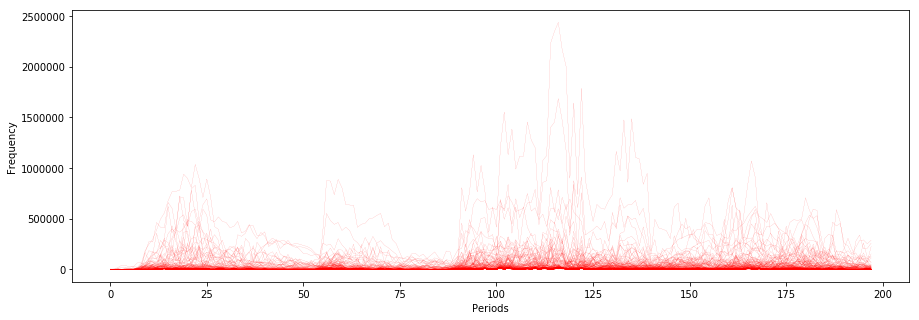

In [10]:
# Line plot of the Fourier transform
plt.figure(figsize = (15, 5))
plt.plot(signal_fft_transform_abs,
         linewidth = 0.08, alpha = 3, color = '#ff0000') 
plt.xlabel("Periods")
plt.ylabel("Frequency")

Text(0.5,0,u'Periods')

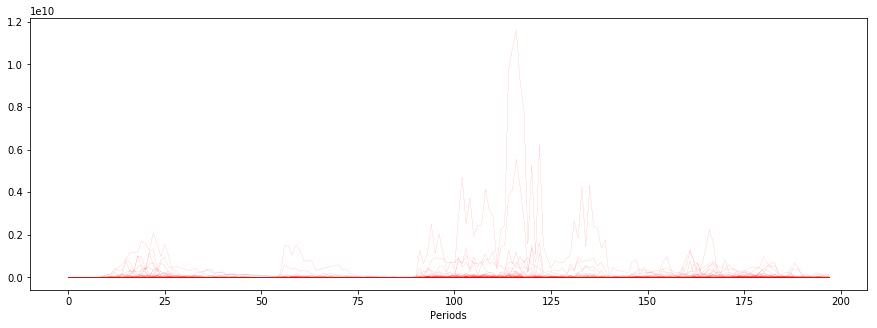

In [11]:
# Line plot of the power spectrum
plt.figure(figsize = (15, 5))
plt.plot(signal_power,
         linewidth = 0.08, alpha = 3, color = '#ff0000')
plt.xlabel("Periods")

Text(0,0.5,u'Frequency (Hz)')

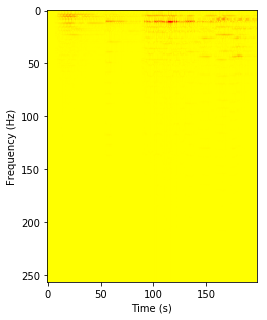

In [12]:
# Plot spectrogram
plt.figure(figsize = (15, 5))
plt.imshow(signal_fft_transform_abs.T, cmap = plt.get_cmap('autumn_r'))
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")

In [88]:
# These need to be in a loop
song_name = song_name     # Name of all songs in a database
#########

# Create an empty list to contain song name and FFT frame
song_fft_window = []

# Create empty lists for each frequency band
band_0_25 = []
band_26_50 = []
band_51_75 = []
band_76_100 = []
band_101_125 = []
band_126_150 = []
band_151_175 = []
band_176_200 = []
band_201_225 = []
band_226_250 = []


# 1. Define the length of each frequency bin by deciding how many bins I need and then chunk the output from FFT by each bin
# When NFFT = 512, the result has 257 datapoints from which I subtract 7 to round the bins
npoints = signal_fft_transform_abs[0].shape[0] - 7
frequency_bins = 10
points_per_bin = npoints / frequency_bins

# 2. Create frequency bins from the indices of all frequencies in the range 0 - 250 (for NFFT = 512) in step of 25 
frames_idx = np.tile(np.arange(0, points_per_bin, 1), (frequency_bins, 1)) + np.tile(np.arange(0, npoints, points_per_bin), (points_per_bin, 1)).T


### -->> Loop through all songs in the database for which I want to create a fingerprint. Apply Fourier transformation to all (use the code "/GitHub/MusicEngine/3.fft_mfcc_filterbanks.ipynb")

# Loop through all the frames/windows to which Fourier transform was applied
for i in range(0, signal_fft_transform_abs.shape[0]):
    
    # 3. Limit the output from the Fourier transform only to the first 250 points (for NFFT = 512)
    fft_results = signal_fft_transform_abs[i, 0:npoints]

    # 4. Split the results from the Fourier transform into the frequency bins defined in (1)
    fft_results_tiled = fft_results[frames_idx]

    # 5. Calculate the maximum power in each bin
    # This returns a list with the maximum power in (1) each frequency bin for (2) each window frame of the audio signal
    max_power = [max(fft_results_tiled[x]) for x in range(0, frames_idx.shape[0])]

    # 6. Append the maximum power from each frequency band to the appropriate frequency band lists
    band_0_25.append(max_power[0])
    band_26_50.append(max_power[1])
    band_51_75.append(max_power[2])
    band_76_100.append(max_power[3])
    band_101_125.append(max_power[4])
    band_126_150.append(max_power[5])
    band_151_175.append(max_power[6])
    band_176_200.append(max_power[7])
    band_201_225.append(max_power[8])
    band_226_250.append(max_power[9])

    # 7. Create an index which is a combination of song name and Fourier transform frame. This index tracks songs and frame sequence
    # The number of records in this list should equal the number of records in the lists with frquency bands
    fft_window = i            # A sequential number of the Fourier transform windows for each song
    song_fft_window.append(song_name + "_" + str(fft_window))
